In [109]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from collections import defaultdict

In [3]:
import nltk
import random
#from nltk.corpus import movie_reviews
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [4]:
def read_files():
    d = defaultdict(list)

    parent_dir = '../Data Sets/'

    path_dic = {'B': 'business_s.csv', 'C':'checkin.csv', 'R':'review_s.csv'\
               , 'T':'tip.csv', 'U':'user.csv'}

    for key in path_dic:
        d[key] = pd.read_csv(parent_dir + path_dic[key]).drop('Unnamed: 0', 1)
    return d
def show():
    sns.despine()
    plt.show()
    
def clean_format(w):
    w = w.lower().replace('.', '').replace(',', '').replace('!', '')
    #.replace('+', '').replace('(', '').replace(')', '')
    return w
                    


In [5]:
d = read_files()

# NLTK: creating classifiers, pickle them

In [35]:
d['RB'] = d['R'].merge(d['B'], on = 'business_id', how = 'inner')
d['RB'] = d['RB'].dropna(subset = ['is_open'])

In [36]:
d['RB'].rename(columns = {'stars_x' : 'review_star', 'stars_y':'buz_star'}, inplace = True)
d['RB'].head(1)

,business_id,cool,date,funny,review_id,review_star,text,useful,user_id,address,...,latitude,longitude,name,neighborhood,postal_code,review_count,buz_star,state,price,credit_card
0,fjMXGgOr3aCxnN48kovZ_Q,0,2015-03-09,0.0,3BBCHVND9tDPNliTFoLCHA,5.0,We recently decided to give this place another...,0.0,bCrpStRCku_gEX3Iwuv94A,5051 W Craig Rd,...,36.238959,-115.211568,Craig Road Animal Hospital,Northwest,89130,192,4.0,NV,NaN,NaN


In [37]:
print(list(d['RB']))

['business_id', 'cool', 'date', 'funny', 'review_id', 'review_star', 'text', 'useful', 'user_id', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'neighborhood', 'postal_code', 'review_count', 'buz_star', 'state', 'price', 'credit_card']


# NLTK preparation

In [38]:
documents = [(t, star) for t,star in zip(d['RB']['text'], d['RB']['review_star'])]

save_documents = open("pickled_algos/documents.pickle","wb")
pickle.dump(documents, save_documents)
save_documents.close()

Let's take look at the first review:

In [39]:
print(documents[0])

("We recently decided to give this place another try after having issues at our normal vet and I'm very glad we did! We transferred all of our pets records over here and plan on using them and only them. The receptionists are always on top of everything, friendly and helpful. Both the vet techs as well as the vets have also been very friendly, helpful and knowledgeable. We had an incident with one of or dogs, Miracle, and Dr.Finder took GREAT care of her and now Miracle LOVES her. We are very pleased with the treatment our animals have been receiving here!", 5.0)


In [40]:
# We will use the stemmer to stem all the words
ps = PorterStemmer()
example_words = ["python","pythoner","pythoning","pythoned","pythonly"]

print([ps.stem(w) for w in example_words])

['python', 'python', 'python', 'python', 'pythonli']


Remove stop words? Something to consider. But turned out this decreases accuracy...

In [12]:
from nltk.corpus import stopwords
 
data = "This is nonsense. I hate this place. The food is bad and the service is terrible"
stopWords = list(set(stopwords.words('english')))

# stopWords[:5]
print(' '.join([w for w in data.split() if w not in stopWords ]))

This nonsense. I hate place. The food bad service terrible


In [41]:
all_words = []

for (t, star) in documents:
    for word in t.split():
        w = clean_format(word)
        all_words.append(ps.stem(w))
        
all_words = nltk.FreqDist(all_words)
print(all_words.most_common(15))
print("stupid appeared: " + str(all_words['stupid']) + " times")

[('the', 25207), ('and', 17402), ('i', 13434), ('a', 12866), ('to', 12566), ('wa', 9003), ('of', 7497), ('it', 6576), ('for', 6096), ('is', 5996), ('in', 5677), ('my', 4878), ('that', 4374), ('with', 4131), ('we', 4044)]
stupid appeared: 26 times


In [42]:
words_features = [s for (s,_) in list(all_words.most_common(5000))]

save_word_features = open("pickled_algos/word_features5k.pickle","wb")
pickle.dump(words_features, save_word_features)
save_word_features.close()

print(words_features[:10])

['the', 'and', 'i', 'a', 'to', 'wa', 'of', 'it', 'for', 'is']


In [49]:
def find_features(document):
    words = set(document.split())
    features = {}
    for w in words:
        w = clean_format(w)
        w = ps.stem(w)
        features[w] = (w in words_features)
    return features

featuresets = [(find_features(doc), star) for (doc,star) in documents]

print(featuresets[0])

({'one': True, 'took': True, 'to': True, 'we': True, 'plan': True, 'help': True, 'recent': True, 'glad': True, 'tri': True, 'drfinder': False, 'now': True, 'great': True, 'all': True, 'top': True, 'the': True, 'anim': True, 'an': True, 'her': True, 'pleas': True, 'at': True, 'thi': True, 'care': True, 'well': True, 'anoth': True, 'been': True, 'receiv': True, 'normal': True, 'here': True, 'record': True, 'on': True, 'knowledg': True, 'and': True, 'miracl': True, 'after': True, 'of': True, 'or': True, 'incid': True, 'have': True, 'alway': True, 'transfer': True, "i'm": True, 'them': True, 'over': True, 'treatment': True, 'dog': True, 'our': True, 'did': True, 'use': True, 'are': True, 'receptionist': True, 'veri': True, 'tech': True, 'onli': True, 'everyth': True, 'pet': True, 'as': True, 'give': True, 'had': True, 'friendli': True, 'with': True, 'both': True, 'decid': True, 'love': True, 'place': True, 'also': True, 'vet': True, 'issu': True}, 5.0)


In [50]:
len(featuresets)

4349

In [51]:
# POS to NEG encode
temp = []
pos_count = 0
for i in range(len(featuresets)):
    if featuresets[i][1] >= 4:
        temp.append((featuresets[i][0], 'pos'))
        pos_count = pos_count + 1
    elif featuresets[i][1] <= 2:
        temp.append((featuresets[i][0], 'neg'))
print("pos rate: ", pos_count / len(temp))
print("len of temp: ", len(temp))

pos rate:  0.7429245283018868
len of temp:  3816


# Trying out some clfs

In [52]:
training_set = temp[:3000]
testing_set = temp[3000:]

print(len(training_set))
print(len(testing_set))

3000
816


In [53]:
np.random.seed(4747)

clf = nltk.NaiveBayesClassifier.train(training_set)
print("Naive Bayes Classifier accuracy: ", nltk.classify.accuracy(clf, testing_set) * 100)
clf.show_most_informative_features(15)

Naive Bayes Classifier accuracy:  46.200980392156865
Most Informative Features
                  refund = True              neg : pos    =     49.9 : 1.0
                    zero = True              neg : pos    =     23.2 : 1.0
                   bewar = True              neg : pos    =     21.7 : 1.0
                    rude = True              neg : pos    =     21.7 : 1.0
                  garbag = True              neg : pos    =     19.8 : 1.0
                    dirt = True              neg : pos    =     19.8 : 1.0
                   ignor = True              neg : pos    =     18.6 : 1.0
                 terribl = True              neg : pos    =     18.5 : 1.0
              underwhelm = True              neg : pos    =     17.9 : 1.0
               tasteless = True              neg : pos    =     17.9 : 1.0
                knowledg = True              pos : neg    =     17.8 : 1.0
                    shut = True              neg : pos    =     16.0 : 1.0
                  int

## Combing multiple classifiers

In [54]:
np.random.seed(4747)

classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

###############
save_classifier = open("pickled_algos/originalnaivebayes5k.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos/MNB_classifier5k.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos/BernoulliNB_classifier5k.pickle","wb")
pickle.dump(BernoulliNB_classifier, save_classifier)
save_classifier.close()

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

save_classifier = open("pickled_algos/LogisticRegression_classifier5k.pickle","wb")
pickle.dump(LogisticRegression_classifier, save_classifier)
save_classifier.close()

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

save_classifier = open("pickled_algos/LinearSVC_classifier5k.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)

save_classifier = open("pickled_algos/NuSVC_classifier5k.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()

SGDC_classifier = SklearnClassifier(SGDClassifier())
SGDC_classifier.train(training_set)
print("SGDClassifier accuracy percent:",nltk.classify.accuracy(SGDC_classifier, testing_set)*100)

save_classifier = open("pickled_algos/SGDC_classifier5k.pickle","wb")
pickle.dump(SGDC_classifier, save_classifier)
save_classifier.close()

Original Naive Bayes Algo accuracy percent: 46.200980392156865
Most Informative Features
                  refund = True              neg : pos    =     49.9 : 1.0
                    zero = True              neg : pos    =     23.2 : 1.0
                   bewar = True              neg : pos    =     21.7 : 1.0
                    rude = True              neg : pos    =     21.7 : 1.0
                  garbag = True              neg : pos    =     19.8 : 1.0
                    dirt = True              neg : pos    =     19.8 : 1.0
                   ignor = True              neg : pos    =     18.6 : 1.0
                 terribl = True              neg : pos    =     18.5 : 1.0
              underwhelm = True              neg : pos    =     17.9 : 1.0
               tasteless = True              neg : pos    =     17.9 : 1.0
                knowledg = True              pos : neg    =     17.8 : 1.0
                    shut = True              neg : pos    =     16.0 : 1.0
           

Now let's combine the clfs！

In [56]:
class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        chosen_class = votes.count(mode(votes))
        return chosen_class / len(votes)
    
voted_classifier = VoteClassifier(MNB_classifier,
                                  LogisticRegression_classifier, 
                                  LinearSVC_classifier) 
#                                   MNB_classifier, 
#                                   NuSVC_classifier)
print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)


voted_classifier accuracy percent: 91.54411764705883


91.54 % is really impressive!!!!!!!

In [89]:
def sentiment(text):
    feats = find_features(text)
    return voted_classifier.classify(feats),voted_classifier.confidence(feats)

# Looking at the misclassified ones...

In [99]:
res = defaultdict(list)

# take the test set
temp_documents = documents[3000:]

for i in range(len(temp_documents)):
    pred, conf = sentiment(temp_documents[i][0])
    res['text'].append(temp_documents[i][0])
    res['confidence'].append(conf)
    res['predicted'].append(pred)
    res['actual'].append(temp_documents[i][1])
res = pd.DataFrame(res)
res.head()

,actual,confidence,predicted,text
0,2.0,0.666667,neg,You read all the reviews and get the idea what...
1,5.0,1.000000,pos,Heather does the best massages around! So rela...
2,5.0,1.000000,pos,We went to this location on Friday evening and...
3,3.0,0.666667,neg,"I will admit, I am not a pinterest fan. I kind..."
4,5.0,1.000000,pos,The food here is great if you're looking for s...


In [102]:
res['actual_encode'] = np.where((res['actual'] == 4.0) | (res['actual'] == 5.0), 'pos', 'neg')

misclassified = res[res['actual_encode'] != res['predicted']]
misclassified = misclassified[misclassified['actual']!=3]
misclassified.index = range(len(misclassified))
print("number of misclassifications: ", len(misclassified))
print("misclassification rate: ", len(misclassified) / len(temp_documents))
misclassified.head()

number of misclassifications:  69
misclassification rate:  0.05114899925871016


,actual,confidence,predicted,text,actual_encode
0,2.0,1.000000,pos,"Large location, but when we went on weekend lu...",neg
1,2.0,1.000000,pos,This place is just so average... Really. I gu...,neg
2,1.0,0.666667,pos,I usually hope that I never have any Starbucks...,neg
3,1.0,0.666667,pos,This week was my 5th visit to this dealership ...,neg
4,2.0,1.000000,pos,Underwhelming. steak was so-so and over priced...,neg


In [105]:
print(misclassified.loc[2, 'text'])

I usually hope that I never have any Starbucks cravings while I'm here because both spots in the mall are by far the crappiest service ever. The barista making drinks gets mad at you if you ask for whipped cream on your drink because the one taking orders didn't mark it on your cup. Overall, each time I've been there it's always sour attitudes morning and night. Not to mention, they are really slow even when there is no line. If you're lucky, you might get that one new person who's smiley and provide great service but the rest are dreadful.


In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.69  0.31]
 [ 0.03  0.97]]


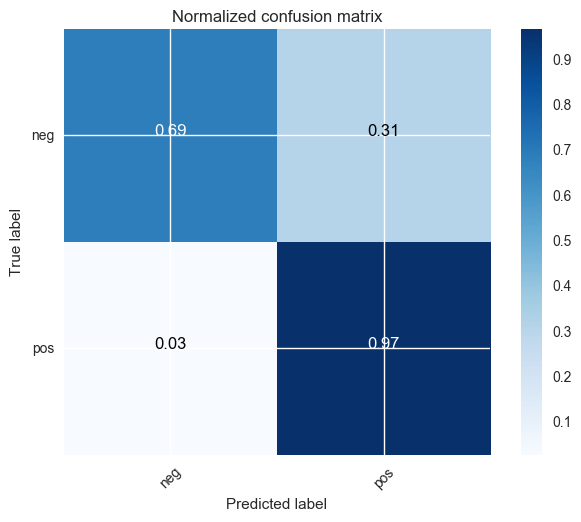

In [119]:
y_test = res['actual_encode']
y_pred = res['predicted']
class_names = ['neg', 'pos']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()